In [50]:
import pandas as pd 
import numpy as np 
import os
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
import warnings 
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Comprehensive EDA started ")
print("*" * 50)

Comprehensive EDA started 
**************************************************


# Load and Prepare Data 

In [20]:
df = pd.read_csv('../data/processed/credit_card_fraud_clean.csv')
print(f"Dataset loaded: {df.shape}")

X = df.drop('Class', axis=1)
y = df['Class']

# Separate minority and majority classes
df_minority = df[df['Class'] == 1]
df_majority = df[df['Class'] == 0]

print(f"Minority class samples: {len(df_minority)}")
print(f"Majority class samples: {len(df_majority)}")

Dataset loaded: (10000, 31)
Minority class samples: 250
Majority class samples: 9750


# Detailed Class Distribution Analysis 

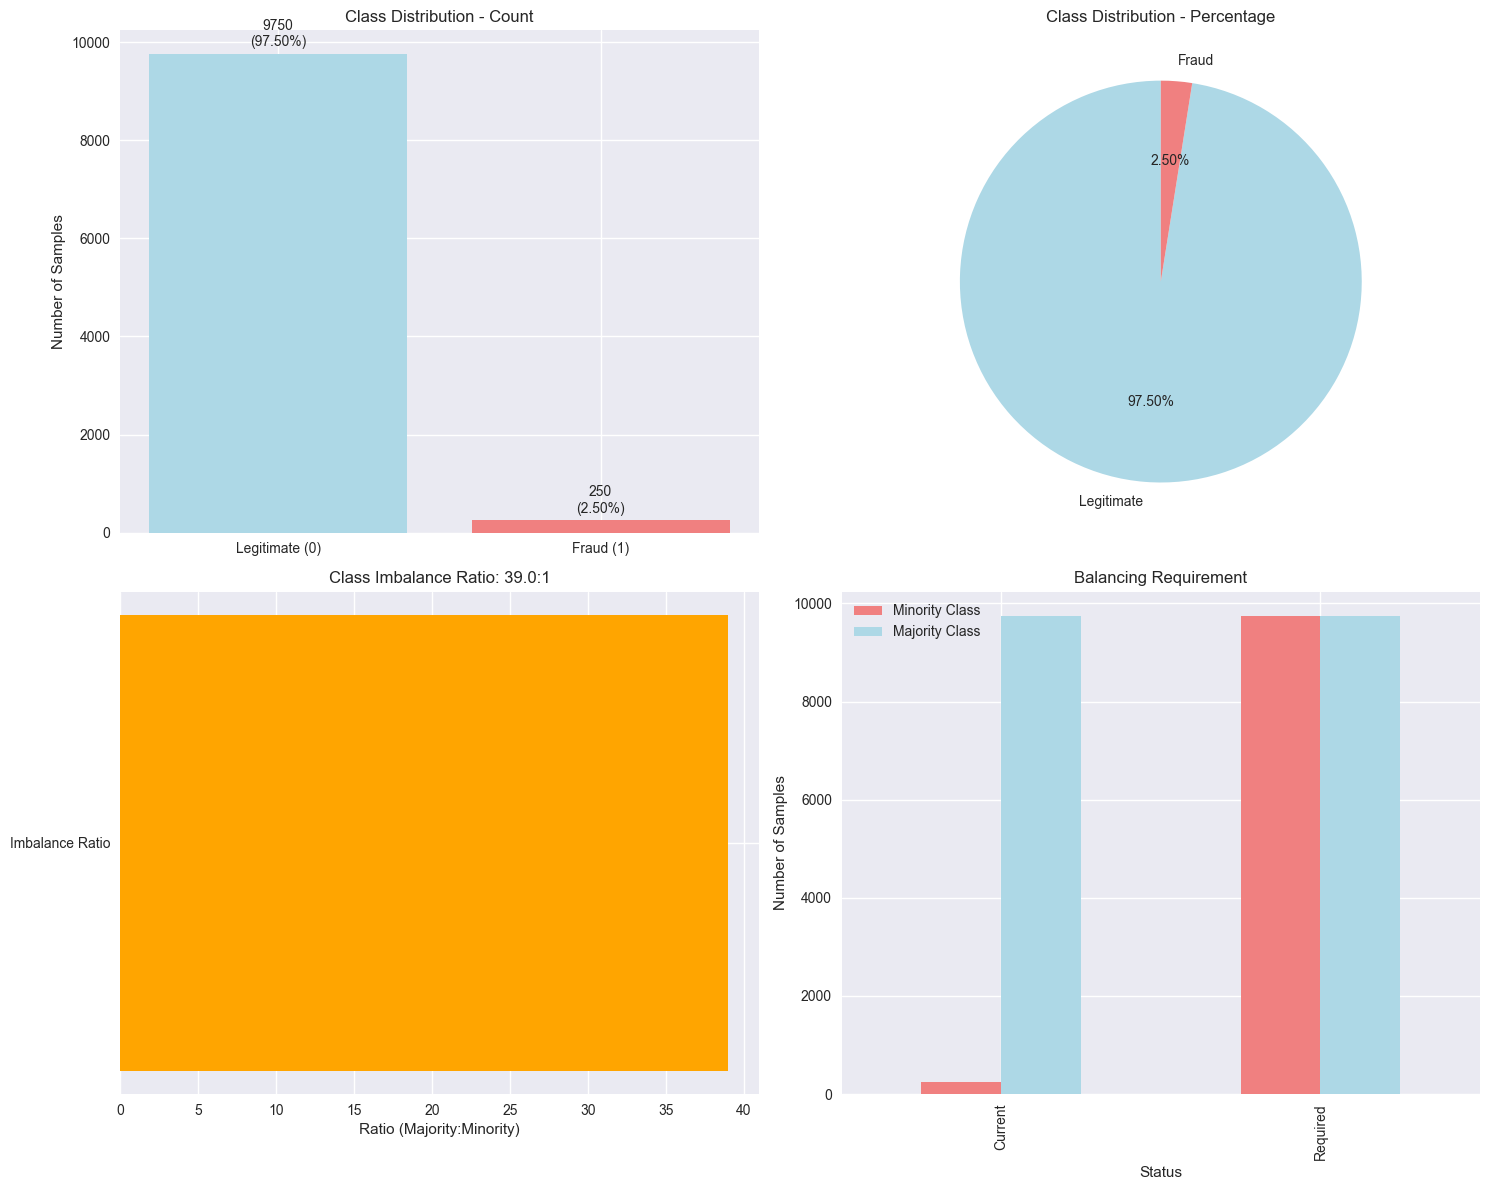

Imbalance Ratio: 39.0:1


In [22]:
def plot_detailed_class_analysis(df, target_col='Class'):
    """Comprehensive class distribution analysis"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    #  Basic class distribution
    class_counts = df[target_col].value_counts()
    class_percentages = df[target_col].value_counts(normalize=True) * 100
    
    axes[0,0].bar(['Legitimate (0)', 'Fraud (1)'], class_counts, 
                  color=['lightblue', 'lightcoral'])
    axes[0,0].set_title('Class Distribution - Count')
    axes[0,0].set_ylabel('Number of Samples')
    
  
    for i, v in enumerate(class_counts):
        axes[0,0].text(i, v + len(df)*0.01, f'{v}\n({class_percentages[i]:.2f}%)', 
                      ha='center', va='bottom')
    
    #  Percentage distribution
    axes[0,1].pie(class_counts, labels=['Legitimate', 'Fraud'], 
                  autopct='%1.2f%%', colors=['lightblue', 'lightcoral'],
                  startangle=90)
    axes[0,1].set_title('Class Distribution - Percentage')
    
    #  Imbalance ratio
    imbalance_ratio = len(df_majority) / len(df_minority)
    axes[1,0].barh(['Imbalance Ratio'], [imbalance_ratio], color='orange')
    axes[1,0].set_title(f'Class Imbalance Ratio: {imbalance_ratio:.1f}:1')
    axes[1,0].set_xlabel('Ratio (Majority:Minority)')
    
    #  Sample needed for balance
    samples_needed = len(df_majority) - len(df_minority)
    balance_info = pd.DataFrame({
        'Status': ['Current', 'Required'],
        'Minority': [len(df_minority), len(df_majority)],
        'Majority': [len(df_majority), len(df_majority)]
    })
    
    balance_info.set_index('Status').plot(kind='bar', ax=axes[1,1], 
                                         color=['lightcoral', 'lightblue'])
    axes[1,1].set_title('Balancing Requirement')
    axes[1,1].set_ylabel('Number of Samples')
    axes[1,1].legend(['Minority Class', 'Majority Class'])
    
    plt.tight_layout()
    plt.show()
    
    return imbalance_ratio

imbalance_ratio = plot_detailed_class_analysis(df)
print(f"Imbalance Ratio: {imbalance_ratio:.1f}:1")

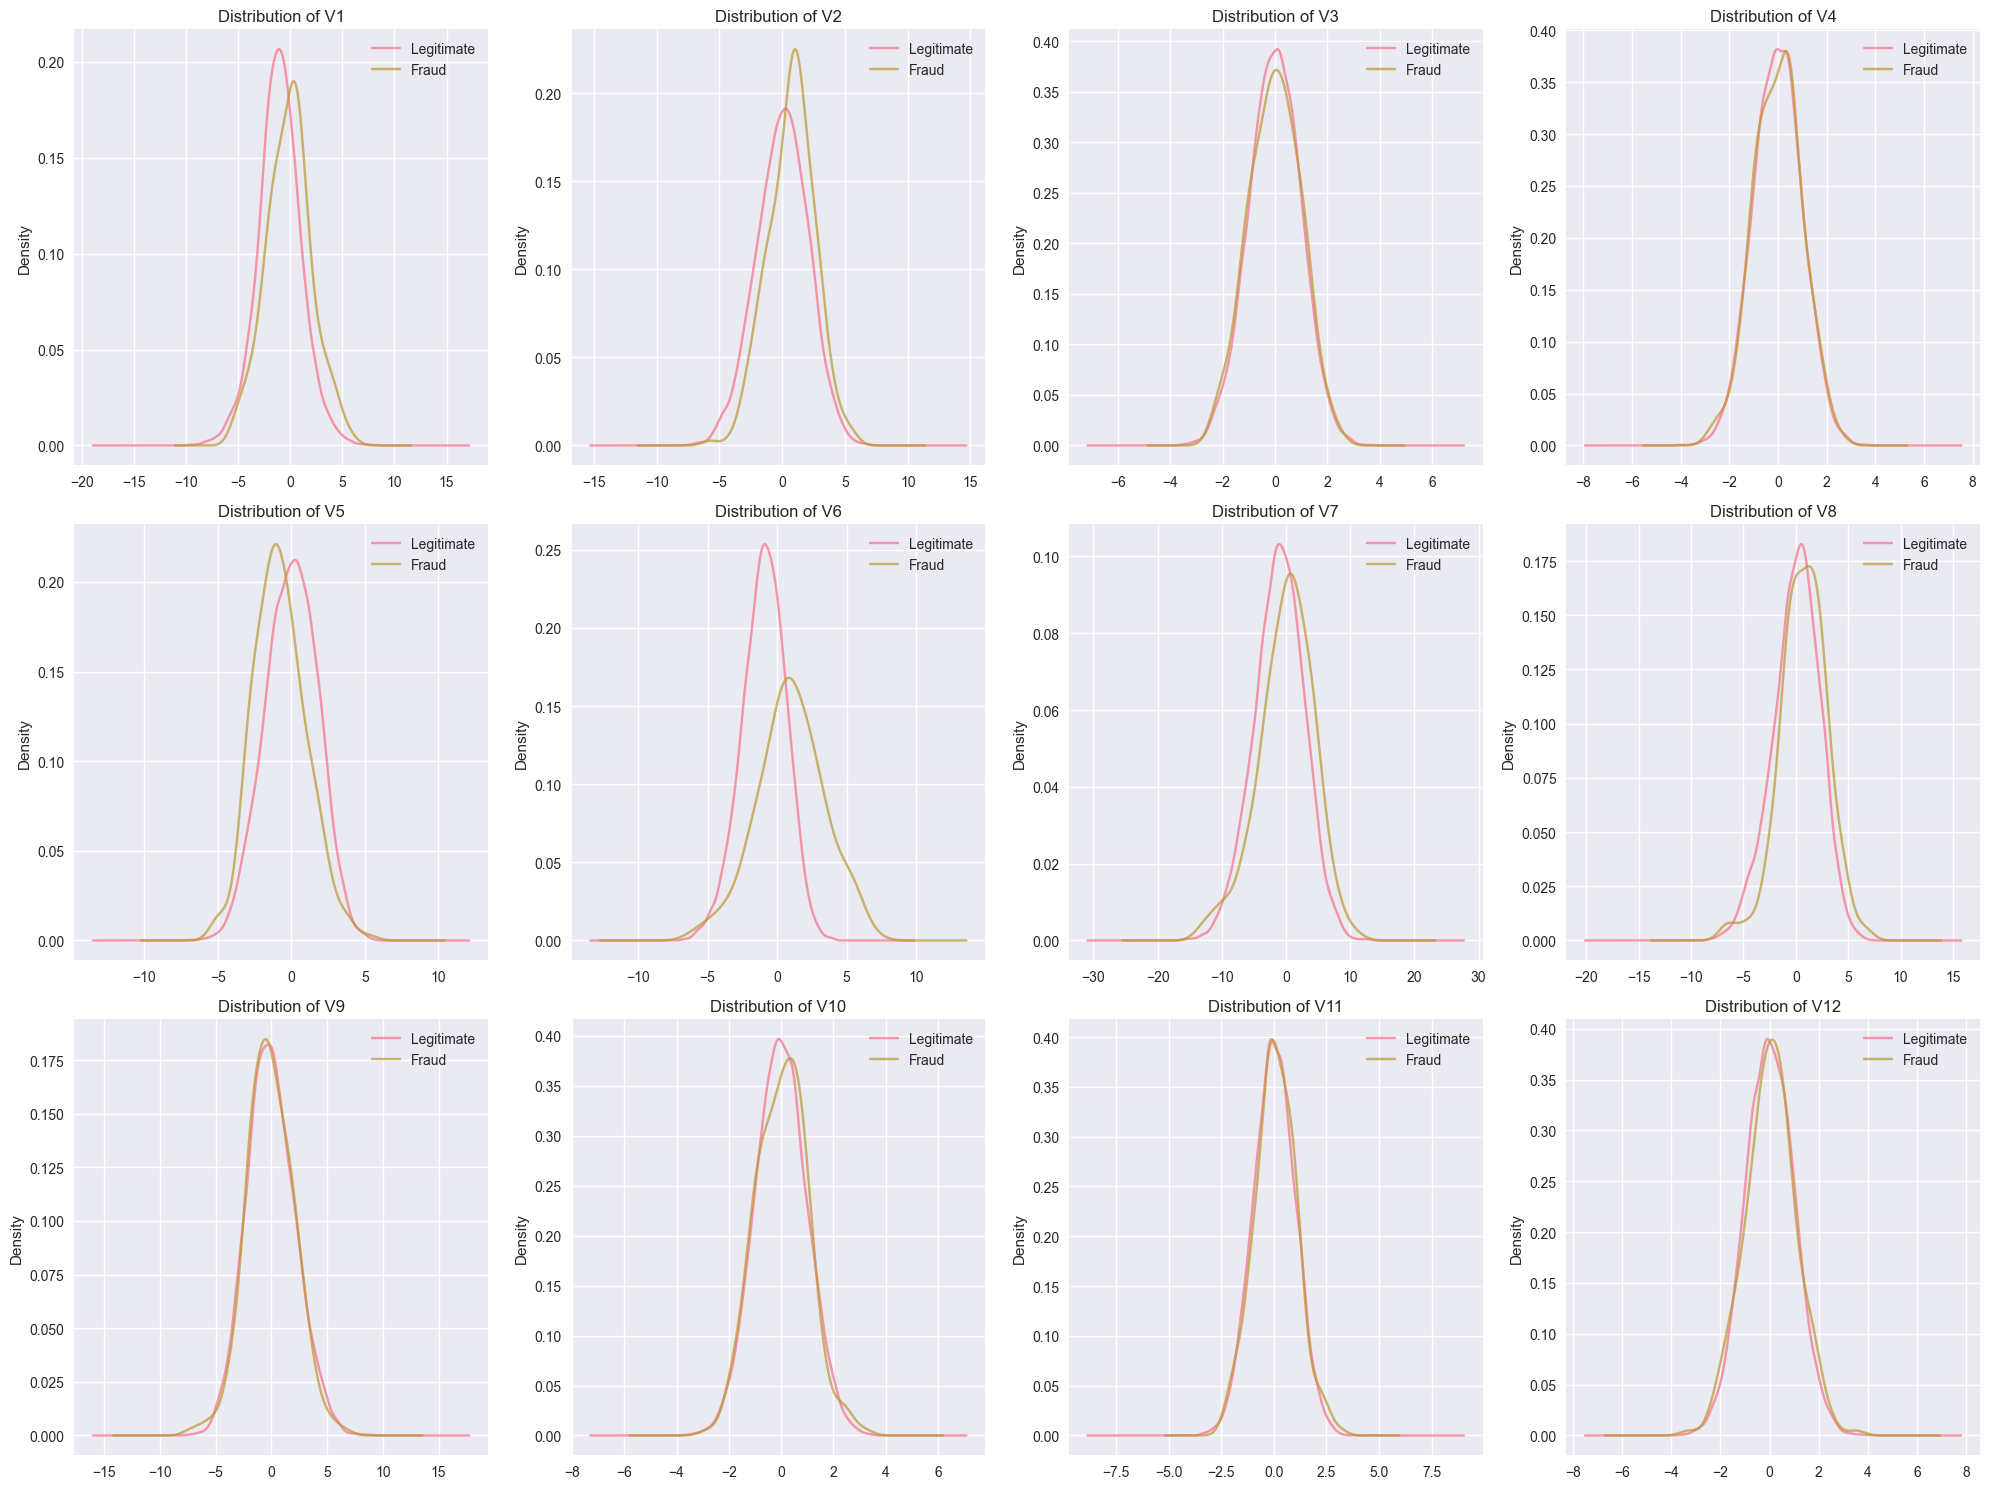

In [23]:
def analyze_feature_distributions(df, target_col='Class'):
    """
    Compare feature distributions between classes
    """
    
    numerical_features = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    n_features = len(numerical_features)
    
    # Plot distributions for first 12 features
    features_to_plot = numerical_features[:12]
    n_rows = 3
    n_cols = 4
    
    fig, axes = plt.subplots(n_rows, 
                             n_cols, 
                             figsize=(20, 15))
    axes = axes.ravel()
    
    for i, feature in enumerate(features_to_plot):
        # Plot KDE for both classes
        df[df[target_col] == 0][feature].plot(kind='kde', 
                                              ax=axes[i], 
                                             label='Legitimate', 
                                              alpha=0.7)
        
        df[df[target_col] == 1][feature].plot(kind='kde', 
                                              ax=axes[i], 
                                             label='Fraud', 
                                              alpha=0.7)
        
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].legend()
        axes[i].set_xlabel('')
    
    # Hide empty subplots
    for i in range(len(features_to_plot), n_rows * n_cols):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return numerical_features

numerical_features = analyze_feature_distributions(df)

# Statistical Distribution of Classes 

=== STATISTICAL COMPARISON BETWEEN CLASSES ===

Top 10 Most Statistically Significant Features:
   feature   cohen_d       p_value  significant
5       V6  0.942173  2.464593e-28         True
18     V19  0.927618  7.873711e-29         True
20     V21  0.526576  1.563830e-12         True
12     V13  0.462586  5.165668e-11         True
23     V24  0.450273  4.776512e-10         True
4       V5  0.426105  1.614610e-10         True
0       V1  0.420138  5.375689e-10         True
16     V17  0.368159  1.471580e-08         True
1       V2  0.364990  5.698853e-09         True
24     V25  0.352808  4.782832e-07         True


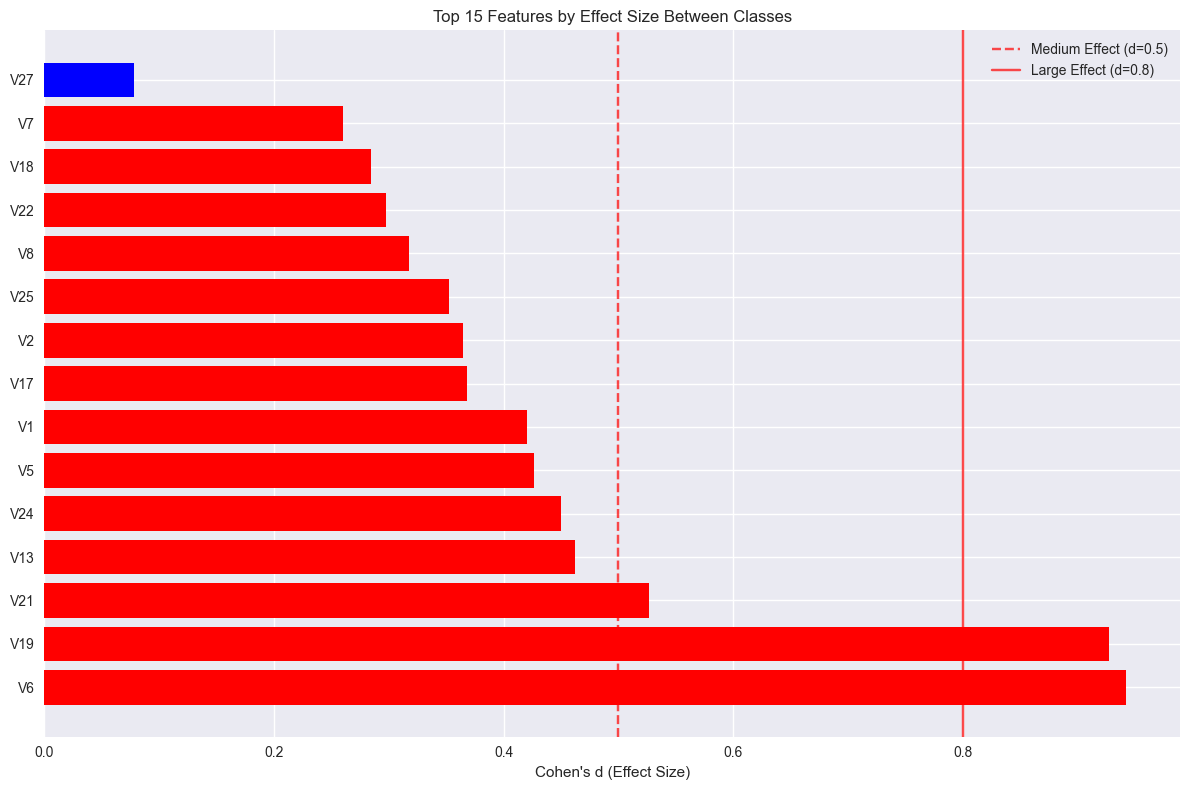

In [25]:
def statistical_class_comparison(df, target_col='Class'):
    """Perform statistical tests between classes"""
    
    print("=== STATISTICAL COMPARISON BETWEEN CLASSES ===")
    
    numerical_features = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    stats_results = []
    
    for feature in numerical_features:
        legit_data = df[df[target_col] == 0][feature]
        fraud_data = df[df[target_col] == 1][feature]
        
        # T-test 
        t_stat, p_value = stats.ttest_ind(legit_data, 
                                          fraud_data, 
                                          equal_var=False)
        
        # Effect size (Cohen's d)
        cohen_d = (legit_data.mean() - fraud_data.mean()) / np.sqrt(
            (legit_data.std()**2 + fraud_data.std()**2) / 2
        )
        
        stats_results.append({
            'feature': feature,
            'legit_mean': legit_data.mean(),
            'fraud_mean': fraud_data.mean(),
            'mean_difference': legit_data.mean() - fraud_data.mean(),
            't_statistic': t_stat,
            'p_value': p_value,
            'cohen_d': abs(cohen_d),
            'significant': p_value < 0.05
        })
    
    stats_df = pd.DataFrame(stats_results)
    
    # significant features
    print("\nTop 10 Most Statistically Significant Features:")
    significant_features = stats_df.nlargest(10, 'cohen_d')[['feature', 'cohen_d', 'p_value', 'significant']]
    print(significant_features)
    
    # Visualize effect sizes
    plt.figure(figsize=(12, 8))
    top_features = stats_df.nlargest(15, 'cohen_d')
    bars = plt.barh(top_features['feature'], top_features['cohen_d'], 
                    color=['red' if sig else 'blue' for sig in top_features['significant']])
    plt.xlabel("Cohen's d (Effect Size)")
    plt.title('Top 15 Features by Effect Size Between Classes')
    plt.axvline(x=0.5, 
                color='red', 
                linestyle='--', 
                alpha=0.7, 
                label='Medium Effect (d=0.5)')
    
    plt.axvline(x=0.8, 
                color='red', 
                linestyle='-', 
                alpha=0.7, 
                label='Large Effect (d=0.8)')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return stats_df

stats_df = statistical_class_comparison(df)

# Correlation Analysis

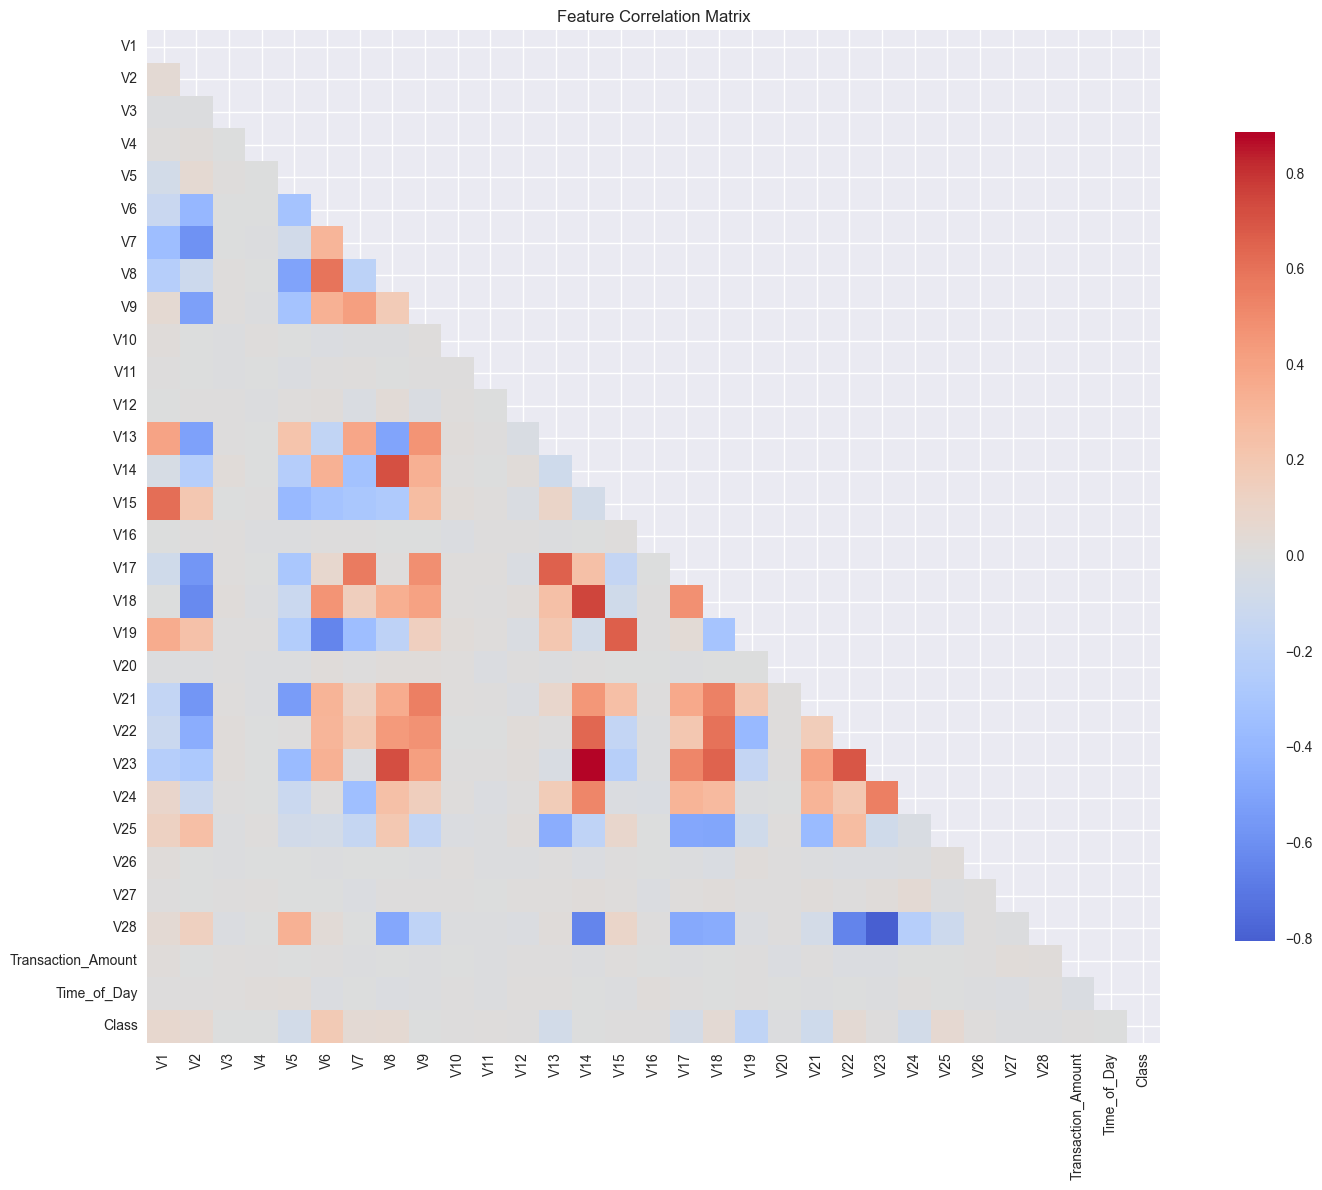

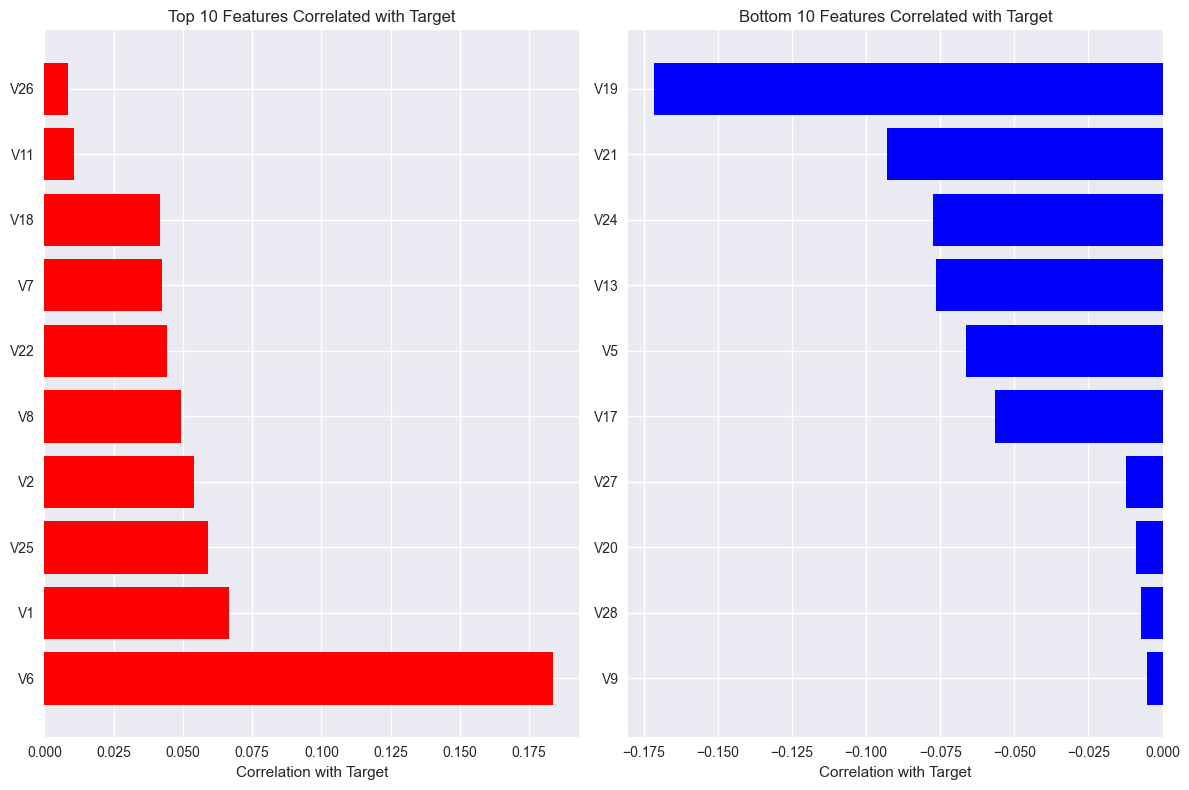

=== CORRELATION ANALYSIS SUMMARY ===
Strongest positive correlation with target: V6 (0.184)
Strongest negative correlation with target: V19 (-0.172)


In [27]:
def comprehensive_correlation_analysis(df, target_col='Class'):
    """Analyze correlations between features and with target"""
    
    corr_matrix = df.corr()
    
    # Plot 
    plt.figure(figsize=(16, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, 
                mask=mask, 
                annot=False, 
                cmap='coolwarm', 
                center=0, 
                square=True, 
                cbar_kws={"shrink": 0.8})
    
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Correlation with target
    target_corr = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
    
   
    plt.figure(figsize=(12, 8))
    top_corr = target_corr.head(10)
    colors = ['red' if x > 0 else 'blue' for x in top_corr.values]
    
    plt.subplot(1, 2, 1)
    plt.barh(range(len(top_corr)), 
             top_corr.values, 
             color=colors)
    plt.yticks(range(len(top_corr)), 
               top_corr.index)
    plt.xlabel('Correlation with Target')
    plt.title('Top 10 Features Correlated with Target')
    
    # Bottom correlations with target
    plt.subplot(1, 2, 2)
    bottom_corr = target_corr.tail(10)
    colors = ['red' if x > 0 else 'blue' for x in bottom_corr.values]
    
    plt.barh(range(len(bottom_corr)), 
             bottom_corr.values, 
             color=colors)
    
    plt.yticks(range(len(bottom_corr)), 
               bottom_corr.index)
    plt.xlabel('Correlation with Target')
    plt.title('Bottom 10 Features Correlated with Target')
    
    plt.tight_layout()
    plt.show()
    
    print("=== CORRELATION ANALYSIS SUMMARY ===")
    print(f"Strongest positive correlation with target: {target_corr.index[0]} ({target_corr.iloc[0]:.3f})")
    print(f"Strongest negative correlation with target: {target_corr.index[-1]} ({target_corr.iloc[-1]:.3f})")
    
    return target_corr

target_corr = comprehensive_correlation_analysis(df)

# Outlier Detection 

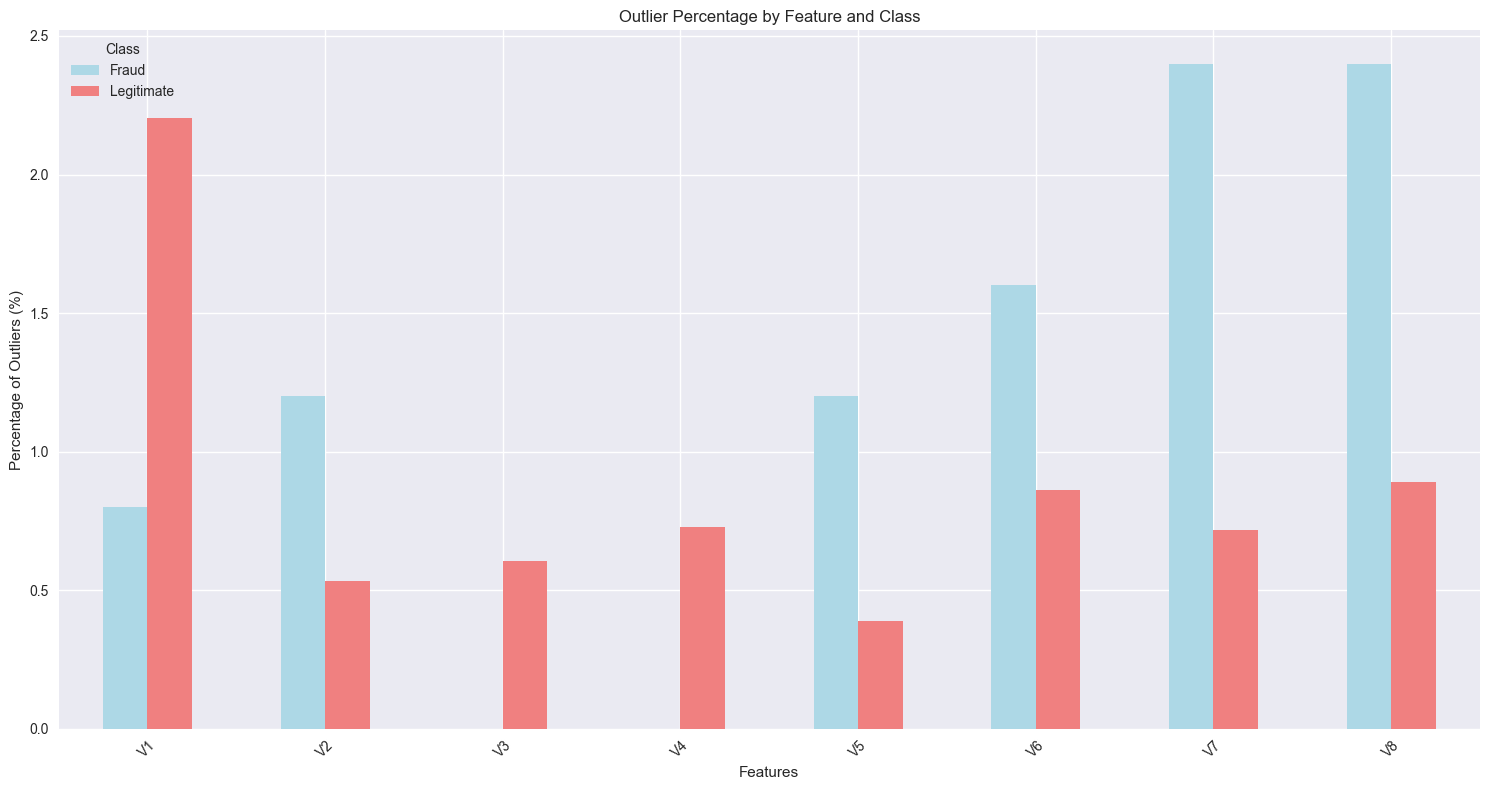

=== OUTLIER ANALYSIS ===
Features with highest outlier percentages:
   feature       class  outlier_percentage
13      V7       Fraud            2.400000
15      V8       Fraud            2.400000
0       V1  Legitimate            2.205128
11      V6       Fraud            1.600000
3       V2       Fraud            1.200000
9       V5       Fraud            1.200000
14      V8  Legitimate            0.892308
10      V6  Legitimate            0.861538
1       V1       Fraud            0.800000
6       V4  Legitimate            0.728205


In [29]:
def outlier_analysis(df, 
                     target_col='Class'):
    """Analyze outliers in both classes"""
    
    numerical_features = df.select_dtypes(include=[np.number]).columns.drop(target_col)
    
    # Calculate outliers using IQR method
    outlier_results = []
    
    for feature in numerical_features[:8]:  # Analyze first 8 features
        for class_val in [0, 1]:
            data = df[df[target_col] == class_val][feature]
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_percentage = (len(outliers) / len(data)) * 100
            
            outlier_results.append({
                'feature': feature,
                'class': 'Legitimate' if class_val == 0 else 'Fraud',
                'outlier_count': len(outliers),
                'outlier_percentage': outlier_percentage
            })
    
    outlier_df = pd.DataFrame(outlier_results)
    
    # Plot outlier analysis
    plt.figure(figsize=(15, 8))
    
    # Pivot for plotting
    outlier_pivot = outlier_df.pivot(index='feature', 
                                     columns='class', 
                                     values='outlier_percentage')
    
    outlier_pivot.plot(kind='bar', 
                       ax=plt.gca(), 
                       color=['lightblue', 'lightcoral'])
    
    plt.title('Outlier Percentage by Feature and Class')
    plt.ylabel('Percentage of Outliers (%)')
    plt.xlabel('Features')
    plt.xticks(rotation=45)
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()
    
    print("=== OUTLIER ANALYSIS ===")
    print("Features with highest outlier percentages:")
    high_outliers = outlier_df.nlargest(10, 'outlier_percentage')
    print(high_outliers[['feature', 'class', 'outlier_percentage']])
    
    return outlier_df

outlier_df = outlier_analysis(df)

# Dimmensional Reduction Visualization 

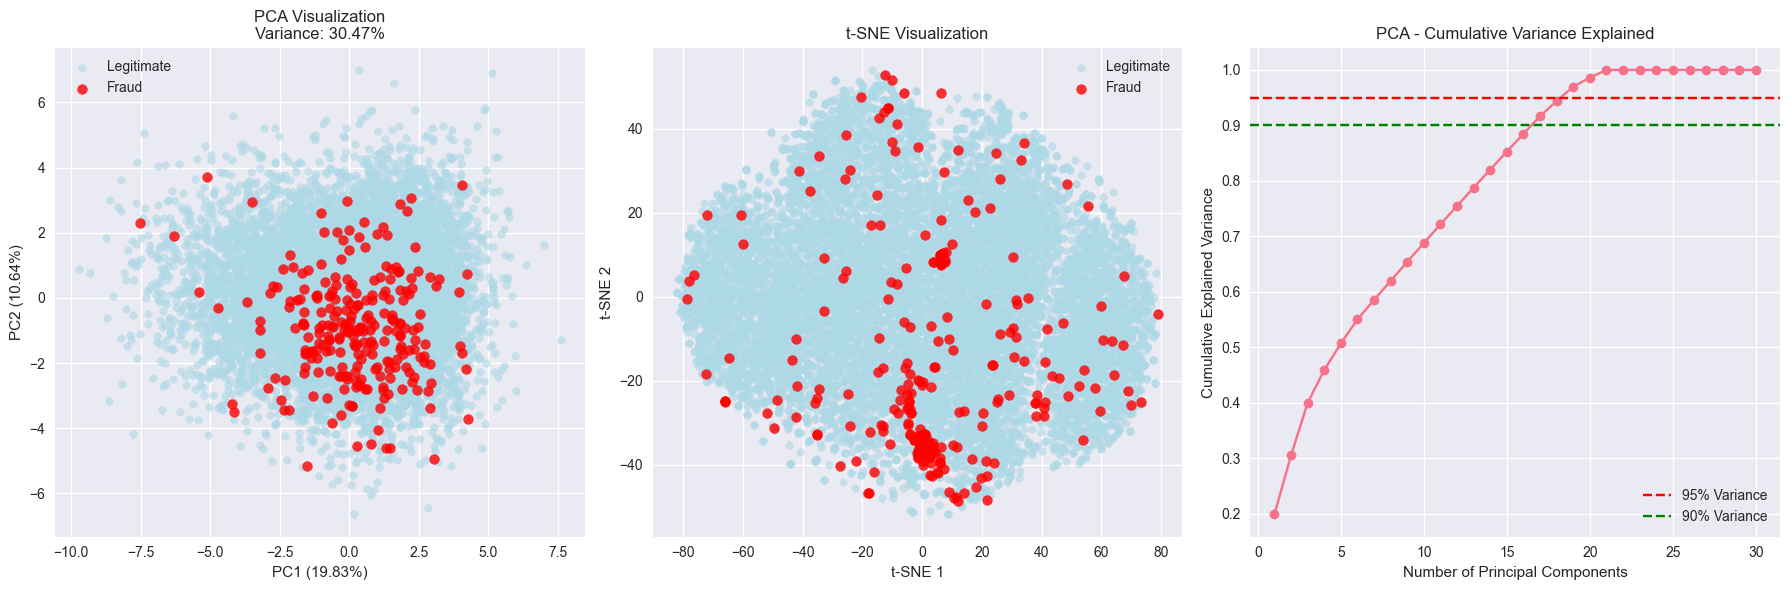

=== DIMENSIONALITY REDUCTION INSIGHTS ===
PCA - Variance explained by first 2 components: 30.47%
PCA - Components needed for 95% variance: 19


In [38]:
def dimensionality_reduction_visualization(df, target_col='Class'):
    """Visualize data in lower dimensions using PCA and t-SNE"""
    
    from sklearn.manifold import TSNE
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Prepare data
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA Visualization
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X_pca = pca.fit_transform(X_scaled)
    
    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # PCA plot
    scatter1 = axes[0].scatter(X_pca[y==0, 0], X_pca[y==0, 1], 
                              c='lightblue', alpha=0.6, label='Legitimate', s=30)
    scatter2 = axes[0].scatter(X_pca[y==1, 0], X_pca[y==1, 1], 
                              c='red', alpha=0.8, label='Fraud', s=50)
    axes[0].set_title(f'PCA Visualization\nVariance: {pca.explained_variance_ratio_.sum():.2%}')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    axes[0].legend()
    
    # t-SNE plot
    axes[1].scatter(X_tsne[y==0, 0], X_tsne[y==0, 1], 
                   c='lightblue', alpha=0.6, label='Legitimate', s=30)
    axes[1].scatter(X_tsne[y==1, 0], X_tsne[y==1, 1], 
                   c='red', alpha=0.8, label='Fraud', s=50)
    axes[1].set_title('t-SNE Visualization')
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    axes[1].legend()
    
    # PCA - Cumulative variance
    pca_full = PCA().fit(X_scaled)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    
    axes[2].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    axes[2].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    axes[2].axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
    axes[2].set_xlabel('Number of Principal Components')
    axes[2].set_ylabel('Cumulative Explained Variance')
    axes[2].set_title('PCA - Cumulative Variance Explained')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print PCA information
    print("=== DIMENSIONALITY REDUCTION INSIGHTS ===")
    print(f"PCA - Variance explained by first 2 components: {pca.explained_variance_ratio_.sum():.2%}")
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"PCA - Components needed for 95% variance: {n_components_95}")
    
    return X_pca, X_tsne, pca

X_pca, X_tsne, pca = dimensionality_reduction_visualization(df)

# Feature Importance Analysis

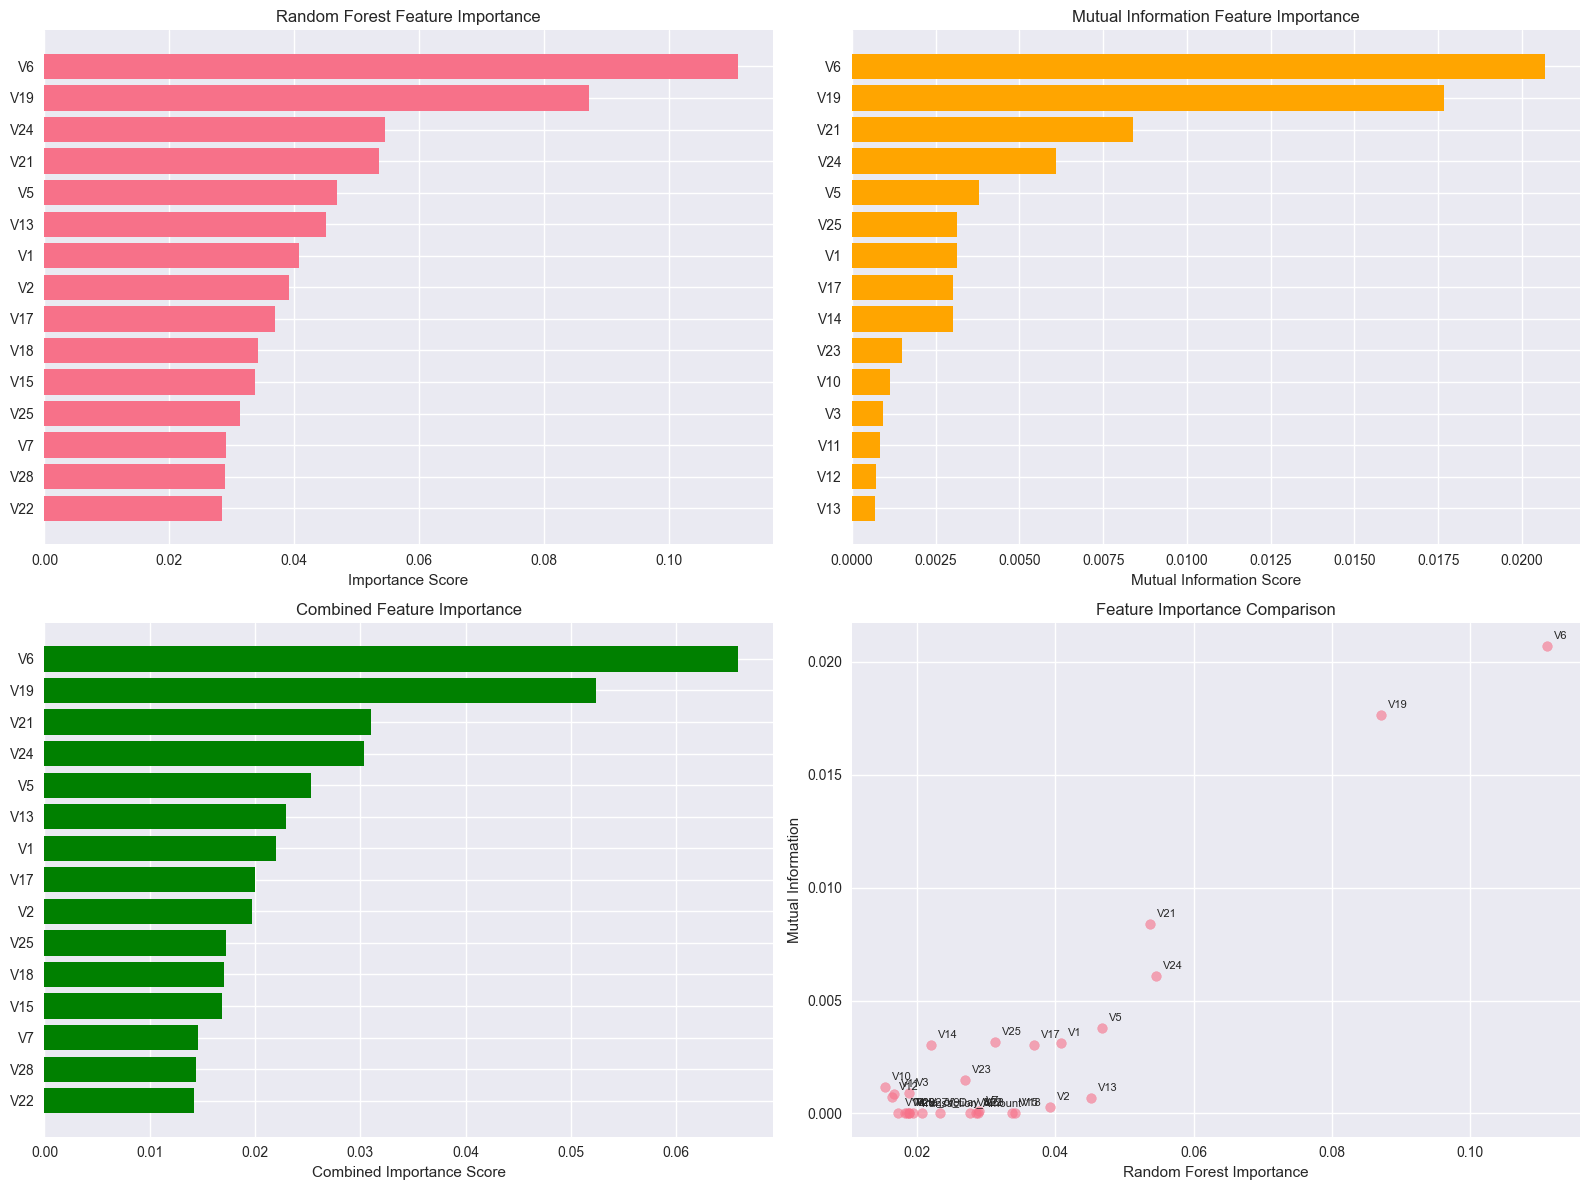

=== TOP 10 MOST IMPORTANT FEATURES ===
   feature  combined_score
0       V6        0.065876
1      V19        0.052404
3      V21        0.031010
2      V24        0.030306
4       V5        0.025292
5      V13        0.022905
6       V1        0.021955
8      V17        0.019974
7       V2        0.019734
11     V25        0.017240


In [41]:
def feature_importance_analysis(df, target_col='Class'):
    """Analyze feature importance using multiple methods"""
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_selection import mutual_info_classif
    from sklearn.preprocessing import StandardScaler
    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Standardize 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    #  Random Forest Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced')
    rf.fit(X_scaled, y)
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'rf_importance': rf.feature_importances_
    }).sort_values('rf_importance', ascending=False)
    
    #  Mutual Information
    mi_scores = mutual_info_classif(X_scaled, y, random_state=RANDOM_STATE)
    mi_importance = pd.DataFrame({
        'feature': X.columns,
        'mutual_info': mi_scores
    }).sort_values('mutual_info', ascending=False)
    
    # Combine results
    importance_df = pd.merge(rf_importance, mi_importance, on='feature')
    importance_df['combined_score'] = (importance_df['rf_importance'] + importance_df['mutual_info']) / 2
    importance_df = importance_df.sort_values('combined_score', ascending=False)
    
 
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Random Forest Importance
    top_rf = rf_importance.head(15)
    axes[0,0].barh(range(len(top_rf)), top_rf['rf_importance'][::-1])
    axes[0,0].set_yticks(range(len(top_rf)))
    axes[0,0].set_yticklabels(top_rf['feature'][::-1])
    axes[0,0].set_xlabel('Importance Score')
    axes[0,0].set_title('Random Forest Feature Importance')
    
    # Mutual Information
    top_mi = mi_importance.head(15)
    axes[0,1].barh(range(len(top_mi)), top_mi['mutual_info'][::-1], color='orange')
    axes[0,1].set_yticks(range(len(top_mi)))
    axes[0,1].set_yticklabels(top_mi['feature'][::-1])
    axes[0,1].set_xlabel('Mutual Information Score')
    axes[0,1].set_title('Mutual Information Feature Importance')
    
    # Combined Importance
    top_combined = importance_df.head(15)
    axes[1,0].barh(range(len(top_combined)), top_combined['combined_score'][::-1], color='green')
    axes[1,0].set_yticks(range(len(top_combined)))
    axes[1,0].set_yticklabels(top_combined['feature'][::-1])
    axes[1,0].set_xlabel('Combined Importance Score')
    axes[1,0].set_title('Combined Feature Importance')
    
    # Feature importance comparison
    axes[1,1].scatter(importance_df['rf_importance'], importance_df['mutual_info'], alpha=0.6)
    for i, row in importance_df.iterrows():
        axes[1,1].annotate(row['feature'], (row['rf_importance'], row['mutual_info']), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].set_xlabel('Random Forest Importance')
    axes[1,1].set_ylabel('Mutual Information')
    axes[1,1].set_title('Feature Importance Comparison')
    
    plt.tight_layout()
    plt.show()
    
    print("=== TOP 10 MOST IMPORTANT FEATURES ===")
    print(importance_df.head(10)[['feature', 'combined_score']])
    
    return importance_df

importance_df = feature_importance_analysis(df)

# Preprocessing strategy 

In [44]:
def create_preprocessing_strategy(df, target_col='Class'):
    """Define preprocessing strategy based on EDA findings"""
    
    print("=== DATA PREPROCESSING STRATEGY ===")
    
    # Identify high-correlation features for potential removal
    corr_matrix = df.corr()
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8 and i != j:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    print(f"High correlation pairs (|r| > 0.8): {len(high_corr_pairs)}")
    
    # Feature selection recommendations
    top_features = importance_df.head(20)['feature'].tolist()
    print(f"\nRecommended top 20 features for modeling:")
    print(top_features)
    
  
    preprocessing_steps = {
        'scaling': 'StandardScaler for all numerical features',
        'feature_selection': f'Top {min(20, len(df.columns)-1)} features based on importance',
        'handling_imbalance': 'Synthetic data generation for minority class',
        'validation': 'Stratified k-fold cross-validation',
        'data_split': 'Stratified train-test split (80-20)'
    }
    
    print("\nPreprocessing Steps:")
    for step, description in preprocessing_steps.items():
        print(f"- {step}: {description}")
    
    return top_features, preprocessing_steps

top_features, preprocessing_steps = create_preprocessing_strategy(df)

=== DATA PREPROCESSING STRATEGY ===
High correlation pairs (|r| > 0.8): 2

Recommended top 20 features for modeling:
['V6', 'V19', 'V21', 'V24', 'V5', 'V13', 'V1', 'V17', 'V2', 'V25', 'V18', 'V15', 'V7', 'V28', 'V22', 'V23', 'V8', 'V14', 'V9', 'V27']

Preprocessing Steps:
- scaling: StandardScaler for all numerical features
- feature_selection: Top 20 features based on importance
- handling_imbalance: Synthetic data generation for minority class
- validation: Stratified k-fold cross-validation
- data_split: Stratified train-test split (80-20)


# EDA Summary and Insights 

In [54]:
def generate_eda_summary(df, target_col='Class'):
    """Generate comprehensive EDA summary"""
    
    print("=" * 60)
    print("EXPLORATORY DATA ANALYSIS - COMPREHENSIVE SUMMARY")
    print("=" * 60)
    
    # Convert numpy types to native Python types for JSON serialization
    summary = {
        'dataset_shape': {
            'samples': int(df.shape[0]),
            'features': int(df.shape[1])
        },
        'minority_class_count': int(len(df[df[target_col] == 1])),
        'majority_class_count': int(len(df[df[target_col] == 0])),
        'imbalance_ratio': float(len(df[df[target_col] == 0]) / len(df[df[target_col] == 1])),
        'missing_values': int(df.isnull().sum().sum()),
        'numerical_features': int(len(df.select_dtypes(include=[np.number]).columns) - 1),
        'highly_correlated_features': int(len([x for x in df.corr().abs().unstack().sort_values(ascending=False).unique() if x > 0.8 and x < 1.0])),
        'top_5_important_features': importance_df.head(5)['feature'].tolist()
    }
    
    print("\nKEY FINDINGS:")
    print(f"1. Dataset: {summary['dataset_shape']['samples']} samples, {summary['dataset_shape']['features']} features")
    print(f"2. Class Imbalance: {summary['imbalance_ratio']:.1f}:1 ratio")
    print(f"3. Minority Class: {summary['minority_class_count']} samples ({summary['minority_class_count']/len(df)*100:.2f}%)")
    print(f"4. Data Quality: {summary['missing_values']} missing values")
    print(f"5. Feature Types: {summary['numerical_features']} numerical features")
    print(f"6. Feature Correlations: {summary['highly_correlated_features']} highly correlated feature pairs")
    print(f"7. Key Features: {', '.join(summary['top_5_important_features'])}")
    
    print("\nRECOMMENDATIONS FOR SYNTHETIC DATA GENERATION:")
    print("✓ Focus on preserving distributions of top important features")
    print("✓ Maintain correlation structure between key features")
    print("✓ Generate synthetic data that captures minority class patterns")
    print("✓ Validate synthetic data using statistical tests and visualization")
    print("✓ Consider feature selection to reduce dimensionality")
    
    return summary

eda_summary = generate_eda_summary(df)


EXPLORATORY DATA ANALYSIS - COMPREHENSIVE SUMMARY

KEY FINDINGS:
1. Dataset: 10000 samples, 31 features
2. Class Imbalance: 39.0:1 ratio
3. Minority Class: 250 samples (2.50%)
4. Data Quality: 0 missing values
5. Feature Types: 30 numerical features
6. Feature Correlations: 2 highly correlated feature pairs
7. Key Features: V6, V19, V21, V24, V5

RECOMMENDATIONS FOR SYNTHETIC DATA GENERATION:
✓ Focus on preserving distributions of top important features
✓ Maintain correlation structure between key features
✓ Generate synthetic data that captures minority class patterns
✓ Validate synthetic data using statistical tests and visualization
✓ Consider feature selection to reduce dimensionality


# Save Result 


EDA results saved to '../results/eda/'
✓ statistical_analysis.csv
✓ feature_importance.csv
✓ target_correlations.json
✓ eda_summary.json
✓ class_distribution.png
✓ top_10_features.png

Phase 2 Completed Successfully!

Ready for Phase 3: Synthetic Data Generation


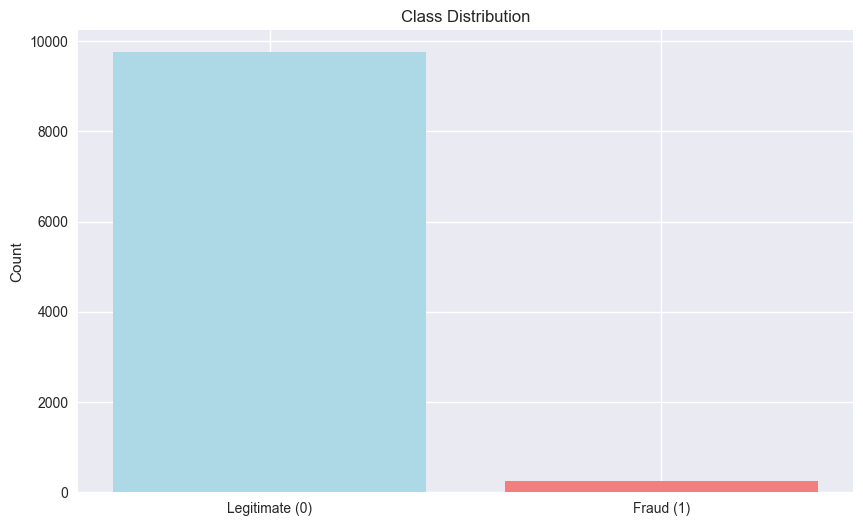

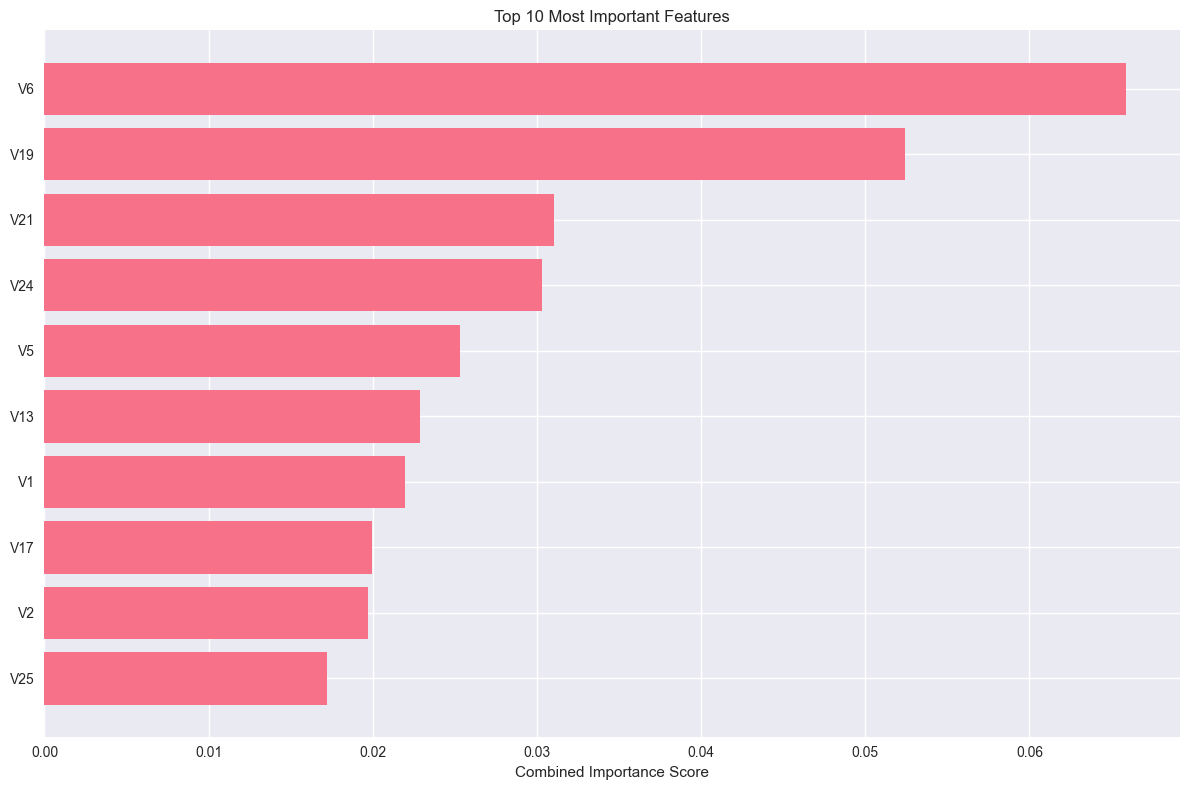

In [58]:
os.makedirs('../results/eda', exist_ok=True)

# Save important dataframes
stats_df.to_csv('../results/eda/statistical_analysis.csv', index=False)
importance_df.to_csv('../results/eda/feature_importance.csv', index=False)

target_corr_dict = target_corr.to_dict()
with open('../results/eda/target_correlations.json', 'w') as f:
    json.dump(target_corr_dict, f, indent=2)


with open('../results/eda/eda_summary.json', 'w') as f:
    json.dump(eda_summary, f, indent=2)

# visualizations
plt.figure(figsize=(10, 6))
class_counts = df['Class'].value_counts()
plt.bar(['Legitimate (0)', 'Fraud (1)'], class_counts, color=['lightblue', 'lightcoral'])
plt.title('Class Distribution')
plt.ylabel('Count')
plt.savefig('../results/eda/class_distribution.png', dpi=300, bbox_inches='tight')

# plot
plt.figure(figsize=(12, 8))
top_10_features = importance_df.head(10)
plt.barh(range(len(top_10_features)), top_10_features['combined_score'][::-1])
plt.yticks(range(len(top_10_features)), top_10_features['feature'][::-1])
plt.xlabel('Combined Importance Score')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.savefig('../results/eda/top_10_features.png', dpi=300, bbox_inches='tight')

print("\nEDA results saved to '../results/eda/'")
print("✓ statistical_analysis.csv")
print("✓ feature_importance.csv") 
print("✓ target_correlations.json")
print("✓ eda_summary.json")
print("✓ class_distribution.png")
print("✓ top_10_features.png")

print("\nPhase 2 Completed Successfully!")
print("\nReady for Phase 3: Synthetic Data Generation")